In [57]:
import pandas as pd
import skore
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    fbeta_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from skrub import tabular_learner, TableVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from pytorch_tabnet.augmentations import ClassificationSMOTE
from skore import CrossValidationReport
from itertools import combinations

from churn_classification_engine.config import settings

In [2]:
DATA_PATH = ".." / settings.data_dir / "train.csv"
OUTPUT_DIR = ".." / settings.reports_dir

TARGET: str = "CHURN"

In [3]:
df = pd.read_csv(DATA_PATH, index_col="CUSTOMER_ID")

In [4]:
df.head()

,COUNTRY_CODE,PLAN_AGE,ACTIVITY_DAY_COUNT,SUPPORT_TICKET_COUNT,DELINQUENCY_DAY_COUNT,PLAN_NAME,BILLING_PERIOD,CURRENCY,MONTHLY_PAYMENT_AMOUNT,DAYS_SINCE_LAST_LOGIN,CHURN
CUSTOMER_ID,,,,,,,,,,,
114383,ES,11,NaN,NaN,NaN,Starter,month,USD,70,NaN,0
116777,GB,7,NaN,NaN,NaN,Pro,month,USD,160,NaN,0
106515,US,21,NaN,NaN,NaN,Pro,year,USD,110,NaN,0
148924,DE,3,NaN,NaN,NaN,Starter,month,EUR,75,NaN,1
193586,FR,1,13.0,NaN,1.0,Starter,month,EUR,75,0.0,0


In [5]:
X = df.drop(columns=TARGET)
y = df[TARGET]

### Evaluation metric

First metric easily interpretable and easy to communicate with business is the **accuracy**.  
But, considering the use of the model, other metrics can be used:  
This model will be used to identify at-risk customers before they churn, to activate establish possible enhancements or interventions.  
In this context, predicting that a customer will churn when he won't (False Positive) is not disastrous. The retention team will simply start the process of contacting the customer and potentially propose a sales action. The margin on this user will potentially be reduced, but this is not as serious as losing a user.  
Then, not predicting that a custommer will churn we he will (False Negative) is worst. When this is the case, the user will no longer generate income.  
We can then use a performance metric that looks like this:
- **Recall**, which measures how many actual churners your model correctly identifies.  
$$\text{Recall} = \frac{True \ Positive}{True \ Positive + False \ Negative}$$

High recall ensures that most of the customers who are at risk of churning are detected.

- **$F_\beta$ Score**, which is a trade off between recall and precision, to not only consider recall.
$$F_{\beta} = (1 + \beta^2) \times \frac{\text{Precision} \times \text{Recall}}{(\beta^2 \times \text{Precision}) + \text{Recall}}$$

The higher the $\beta$, the greater the weight of the recall will be. Then, defining $\beta=2$ gives more weight to recall than precision.

- **Receiver Operating Characteristic - Area Under Curve** and **Precision-Recall AUC** can also be considered.

I think using **$F_\beta$ Score** is a good choice, we can tune the $\beta$ parameter depending on the monetary cost of loosing a customer (predicting as non-churner when he is) and the monetary cost of retaining a satisfied customer (predicting as churner when he is not).  
Without discussion with the business team, I make the simplistic assumption that losing a customer is 2x costly than retaining a satisfied customer, then **$F_2$ Score** can be used as a North star metric.

## Baseline

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
def _get_metrics_df(cv_report: CrossValidationReport) -> pd.DataFrame:
    """
    Generate a DataFrame containing both fold-specific and aggregated metrics from a cross-validation report.

    Args:
        cv_report (CrossValidationReport): The cross-validation report containing metrics data.

    Returns:
        pd.DataFrame: A DataFrame with metrics for each fold and their aggregated statistics, including accuracy
        and F-Score with a beta of 2.
    """
    fold_metrics_df = pd.concat(
        [
            cv_report.metrics.accuracy(),
            cv_report.metrics.custom_metric(
                metric_function=fbeta_score,
                response_method="predict",
                metric_name="F2-Score",
                pos_label=1,
                **{"beta": 2},
            ),
            cv_report.metrics.report_metrics(pos_label=1),
        ]
    )
    agg_metrics_df = pd.concat(
        [
            cv_report.metrics.accuracy(aggregate=["mean", "std"]),
            cv_report.metrics.custom_metric(
                metric_function=fbeta_score,
                response_method="predict",
                metric_name="F2-Score",
                pos_label=1,
                aggregate=["mean", "std"],
                **{"beta": 2},
            ),
            cv_report.metrics.report_metrics(pos_label=1, aggregate=["mean", "std"]),
        ]
    )
    return pd.concat([fold_metrics_df, agg_metrics_df], axis=1)

A DummyClassifier which returns the most frequent class label in the observed `y` argument passed to fit and returns the empirical class distribution of `y` also known as the empirical class prior distribution using `predict_proba()`.

In [8]:
model = DummyClassifier()
model

DummyClassifier()

Output()

Output()

Output()

Output()

/home/psteffen/perso/phantombuster-casestudy/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:
1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use 
`zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/home/psteffen/perso/phantombuster-casestudy/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:
1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use 
`zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/home/psteffen/perso/phantombuster-casestudy/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:
1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use 
`zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/home/psteffen/perso/phantombuster-casestudy/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:
1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use 
`zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/home/psteffen/perso/phantombuster-casestudy/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:
1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use 
`zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Output()

Output()

Output()

Output()

Output()

DummyClassifier                                                    \
                   Split #0  Split #1  Split #2  Split #3  Split #4      mean   
Metric                                                                          
Accuracy           0.841841  0.841841  0.841784  0.841784  0.841784  0.841807   
F2-Score           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Precision          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Recall             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ROC AUC            0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
Brier score        0.133144  0.133144  0.133183  0.133183  0.133183  0.133168   

                       
                  std  
Metric                 
Accuracy     0.000031  
F2-Score     0.000000  
Precision    0.000000  
Recall       0.000000  
ROC AUC      0.000000  
Brier score  0.000021

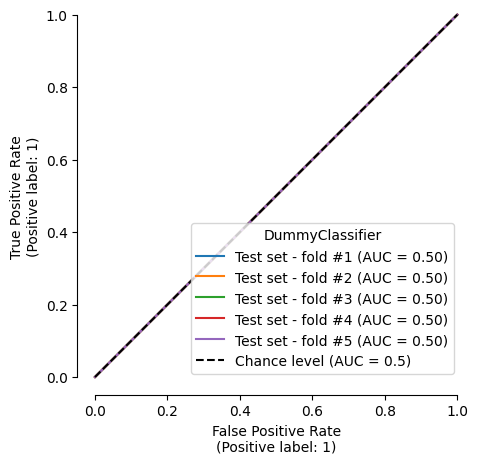

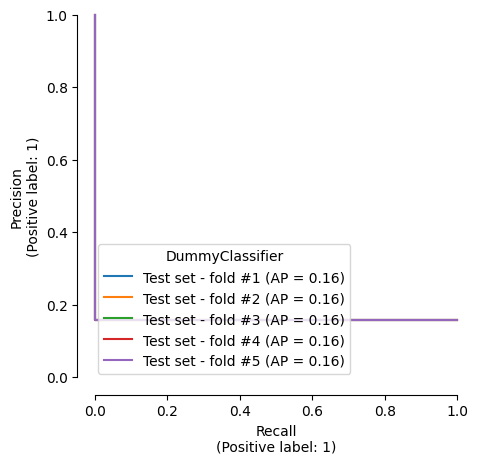

In [9]:
dummy_cv_report = CrossValidationReport(model, X, y, cv_splitter=skf)
dummy_metrics_df = _get_metrics_df(dummy_cv_report)
dummy_cv_report.metrics.roc(pos_label=1).plot()
dummy_cv_report.metrics.precision_recall(pos_label=1).plot()
dummy_metrics_df

A simple machine-learning pipeline for tabular data:
- `TableVectorizer` transforms the tabular data into numeric features. Its parameters are chosen depending on the provided estimator.
- Optional `SimpleImputer` imputes missing values by their mean and adds binary columns that indicate which values were missing. This step is only added if the estimator cannot handle missing values itself.
- optional `StandardScaler` centers and rescales the data. This step is not added (because it is unnecessary) when the estimator is a tree ensemble such as random forest or gradient boosting.
- `HistGradientBoostingClassifier` 

In [10]:
model = tabular_learner("classification")
model

Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

HistGradientBoostingClassifier                                \
                                  Split #0  Split #1  Split #2  Split #3   
Metric                                                                     
Accuracy                          0.843722  0.844975  0.844348  0.843266   
F2-Score                          0.041308  0.039637  0.033443  0.032068   
Precision                         0.607843  0.723577  0.714286  0.610169   
Recall                            0.033501  0.032061  0.027008  0.025927   
ROC AUC                           0.764143  0.760741  0.758011  0.761272   
Brier score                       0.117314  0.117299  0.117722  0.117424   

                                           
             Split #4      mean       std  
Metric                                     
Accuracy     0.843949  0.844052  0.000648  
F2-Score     0.030782  0.035448  0.004720  
Precision    0.690000  0.669175  0.056284  
Recall       0.024847  0.028669  0.003865  
ROC AUC      0.760177  0.760869  0.002210  
Brier score  0.117476  0.117447  0.000171

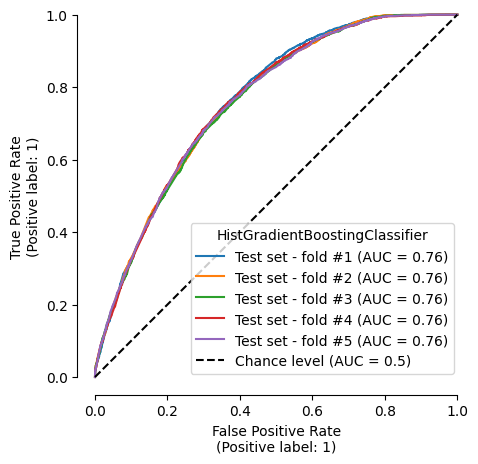

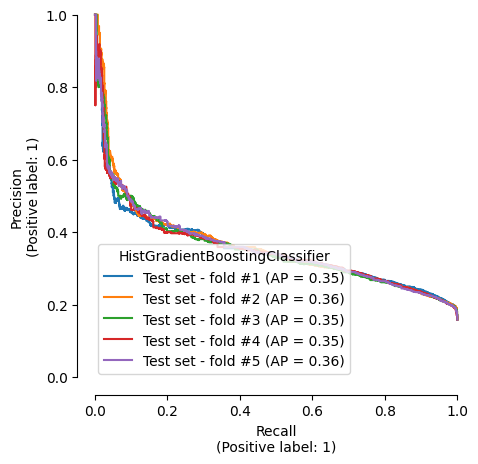

In [11]:
tabular_learner_cv_report = CrossValidationReport(
    model, X, y, cv_splitter=skf, n_jobs=5
)
tabular_learner_metrics_df = _get_metrics_df(tabular_learner_cv_report)
tabular_learner_cv_report.metrics.roc(pos_label=1).plot()
tabular_learner_cv_report.metrics.precision_recall(pos_label=1).plot()
tabular_learner_metrics_df

Very imbalanced dataset, then use a balanced class weight

In [47]:
model = tabular_learner(
    estimator=HistGradientBoostingClassifier(random_state=42, class_weight="balanced")
)
model

Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                random_state=42))])

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

HistGradientBoostingClassifier                                \
                                  Split #0  Split #1  Split #2  Split #3   
Metric                                                                     
Accuracy                          0.657646  0.650752  0.646251  0.660950   
F2-Score                          0.559736  0.557347  0.555526  0.562880   
Precision                         0.280635  0.276460  0.273794  0.283315   
Recall                            0.744957  0.747118  0.747929  0.747209   
ROC AUC                           0.761611  0.760019  0.756435  0.762906   
Brier score                       0.202689  0.203643  0.204618  0.201445   

                                           
             Split #4      mean       std  
Metric                                     
Accuracy     0.647277  0.652575  0.006466  
F2-Score     0.562493  0.559596  0.003195  
Precision    0.276278  0.278096  0.003814  
Recall       0.759093  0.749261  0.005607  
ROC AUC      0.759559  0.760106  0.002444  
Brier score  0.205514  0.203581  0.001595

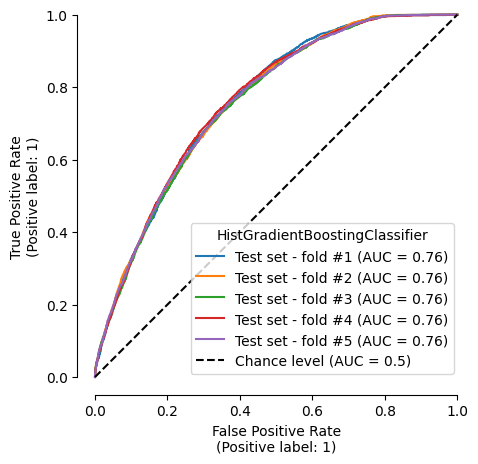

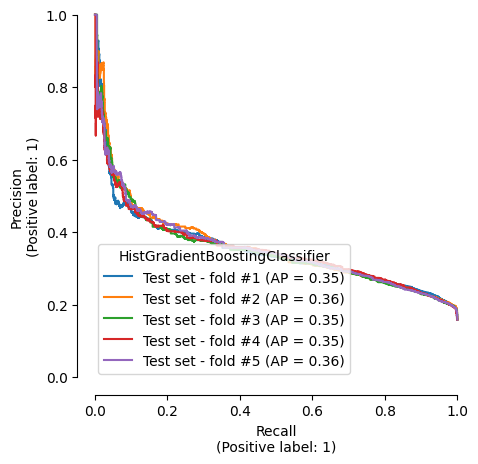

In [48]:
balanced_tabular_learner_cv_report = CrossValidationReport(model, X, y, cv_splitter=skf)
balanced_tabular_learner_metrics_df = _get_metrics_df(balanced_tabular_learner_cv_report)
balanced_tabular_learner_cv_report.metrics.roc(pos_label=1).plot()
balanced_tabular_learner_cv_report.metrics.precision_recall(pos_label=1).plot()
balanced_tabular_learner_metrics_df

Try other tree-based models

In [14]:
model = tabular_learner(
    RandomForestClassifier(random_state=42, class_weight="balanced")
)
model

Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                unknown_value=-1))),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

RandomForestClassifier                                          \
                          Split #0  Split #1  Split #2  Split #3  Split #4   
Metric                                                                       
Accuracy                  0.695533  0.701003  0.697755  0.700262  0.693368   
F2-Score                  0.465718  0.448253  0.442916  0.448563  0.455359   
Precision                 0.274658  0.272711  0.268668  0.272361  0.269836   
Recall                    0.563761  0.534222  0.528628  0.535110  0.549874   
ROC AUC                   0.711267  0.703502  0.699043  0.704525  0.702631   
Brier score               0.182885  0.183852  0.185089  0.181755  0.183978   

                                 
                 mean       std  
Metric                           
Accuracy     0.697584  0.003196  
F2-Score     0.452162  0.008771  
Precision    0.271646  0.002391  
Recall       0.542319  0.014334  
ROC AUC      0.704194  0.004461  
Brier score  0.183512  0.001255

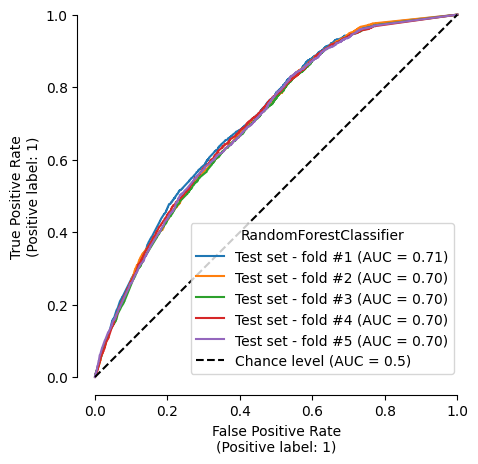

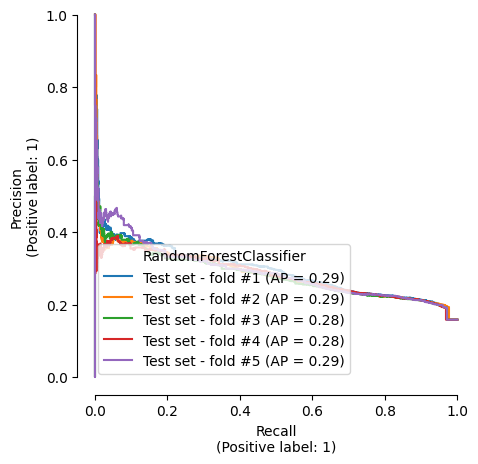

In [15]:
balanced_tabular_learner_rf_cv_report = CrossValidationReport(
    model, X, y, cv_splitter=skf, n_jobs=5
)
balanced_tabular_learner_rf_metrics_df = _get_metrics_df(
    balanced_tabular_learner_rf_cv_report
)
balanced_tabular_learner_rf_cv_report.metrics.roc(pos_label=1).plot()
balanced_tabular_learner_rf_cv_report.metrics.precision_recall(pos_label=1).plot()
balanced_tabular_learner_rf_metrics_df

Try linear model

In [43]:
model = tabular_learner(LogisticRegression(random_state=42, class_weight="balanced"))
model

Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                ('simpleimputer', SimpleImputer(add_indicator=True)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

LogisticRegression                                          \
                      Split #0  Split #1  Split #2  Split #3  Split #4   
Metric                                                                   
Accuracy              0.569109  0.578225  0.577028  0.582042  0.571616   
F2-Score              0.552478  0.547972  0.545770  0.546411  0.537200   
Precision             0.242496  0.244167  0.243175  0.245051  0.238877   
Recall                0.811960  0.795389  0.792222  0.788981  0.781059   
ROC AUC               0.726521  0.723269  0.712846  0.715065  0.710455   
Brier score           0.219978  0.219976  0.221987  0.220110  0.222938   

                                 
                 mean       std  
Metric                           
Accuracy     0.575604  0.005207  
F2-Score     0.545966  0.005557  
Precision    0.242753  0.002374  
Recall       0.793922  0.011405  
ROC AUC      0.717631  0.006925  
Brier score  0.220998  0.001380

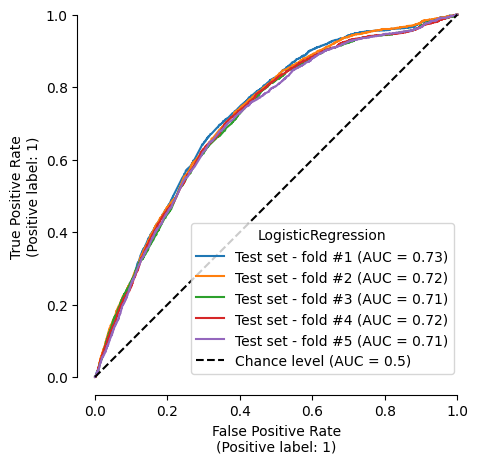

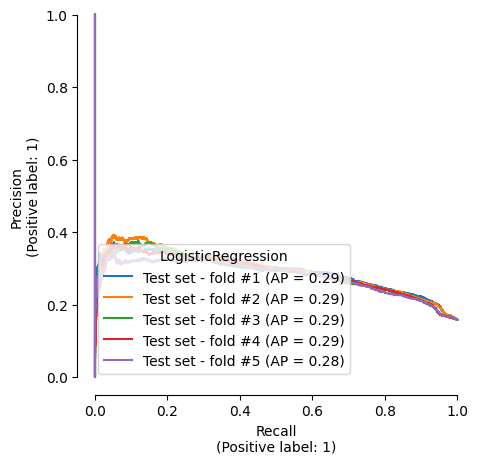

In [44]:
balanced_tabular_learner_lr_cv_report = CrossValidationReport(
    model, X, y, cv_splitter=skf
)
balanced_tabular_learner_lr_metrics_df = _get_metrics_df(
    balanced_tabular_learner_lr_cv_report
)
balanced_tabular_learner_lr_cv_report.metrics.roc(pos_label=1).plot()
balanced_tabular_learner_lr_cv_report.metrics.precision_recall(pos_label=1).plot()
balanced_tabular_learner_lr_metrics_df

Try using SMOTE

In [45]:
from imblearn.pipeline import Pipeline

model = Pipeline(
    [
        ("tablevectorizer", TableVectorizer()),
        ("imputer", SimpleImputer(strategy="constant")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(sampling_strategy=0.5, random_state=42)),
        ("clf", LogisticRegression(class_weight="balanced", random_state=42)),
    ]
)
model

Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                ('imputer', SimpleImputer(strategy='constant')),
                ('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42))])

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

LogisticRegression                                          \
                      Split #0  Split #1  Split #2  Split #3  Split #4   
Metric                                                                   
Accuracy              0.572129  0.574863  0.569337  0.576288  0.560506   
F2-Score              0.553152  0.548690  0.545991  0.547161  0.541669   
Precision             0.243665  0.243261  0.240729  0.243336  0.236693   
Recall                0.810519  0.799712  0.799424  0.795463  0.799064   
ROC AUC               0.727603  0.723611  0.712316  0.718617  0.712949   
Brier score           0.219429  0.219944  0.222153  0.219715  0.223102   

                                 
                 mean       std  
Metric                           
Accuracy     0.570624  0.006252  
F2-Score     0.547333  0.004172  
Precision    0.241537  0.002952  
Recall       0.800836  0.005679  
ROC AUC      0.719019  0.006647  
Brier score  0.220869  0.001650

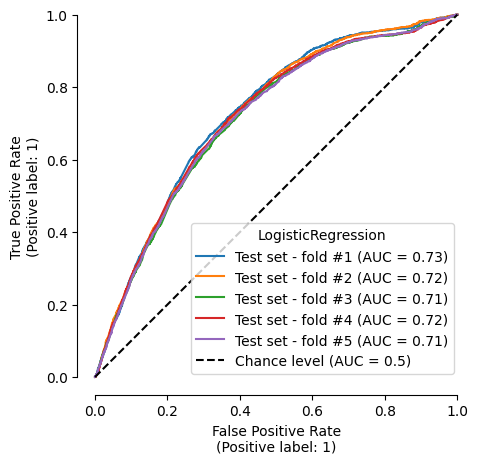

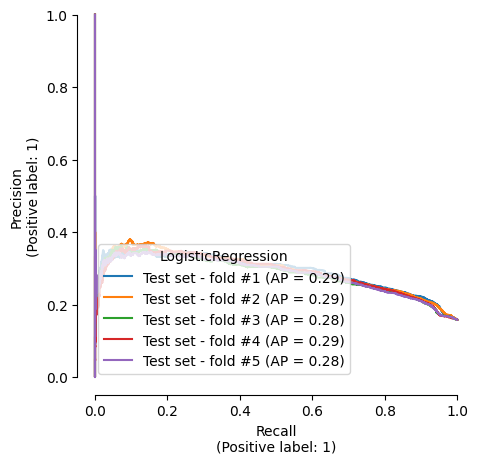

In [46]:
balanced_tabular_learner_smote_lr_cv_report = CrossValidationReport(
    model, X, y, cv_splitter=skf
)
balanced_tabular_learner_smote_lr_metrics_df = _get_metrics_df(
    balanced_tabular_learner_smote_lr_cv_report
)
balanced_tabular_learner_smote_lr_cv_report.metrics.roc(pos_label=1).plot()
balanced_tabular_learner_smote_lr_cv_report.metrics.precision_recall(pos_label=1).plot()
balanced_tabular_learner_smote_lr_metrics_df

In [ ]:
preds = pd.Series()

aug = ClassificationSMOTE(p=0.5)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    prep_pipeline = Pipeline(
        [
            ("tablevectorizer", TableVectorizer()),
            ("imputer", SimpleImputer(strategy="constant")),
            ("scaler", StandardScaler()),
        ]
    )
    clf = TabNetClassifier(
        # lambda_sparse=1e-1,  # Increase sparsity
        # gamma=2,  # Increase gamma for better generalization
        # n_d=2, n_a=2,  # Increase capacity but avoid too much overfitting
        # momentum=0.01,  # Reduce momentum for more stable updates
        # optimizer_params={'lr': 0.005, 'weight_decay': 1e-4},  # Reduce learning rate
        # scheduler_params={'step_size': 10, 'gamma': 0.5}
    )
    X_train_prep = prep_pipeline.fit_transform(X.iloc[train_index])
    X_val_prep = prep_pipeline.transform(X.iloc[test_index])
    clf.fit(
        X_train_prep,
        y.iloc[train_index].values,
        eval_set=[(X_val_prep, y.iloc[test_index].values)],
        eval_metric=['accuracy', 'logloss', 'auc'],
        weights=1,
        #virtual_batch_size=16,
        #augmentations=aug,
    )
    preds = pd.concat([preds, pd.Series(clf.predict_proba(prep_pipeline.transform(X.iloc[test_index]))[:, 1], index=y.iloc[test_index].index)])

In [ ]:
y_true = y.sort_index()
y_prob_pred = preds.sort_index()
y_pred = (y_prob_pred>.5).astype(int)

In [ ]:
fbeta_score(y_true, y_pred, beta=2)

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
display = RocCurveDisplay.from_predictions(
    y_true, 
    y_prob_pred, 
    plot_chance_level=True, 
    despine=True
)

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    y_true, 
    y_prob_pred, 
    plot_chance_level=True, 
    despine=True
)

**Balanced Tabular Learner with HistGradientBoostingClassifier** is selected.

# Bruteforce features selection

In [ ]:
col_combinations = []
for i in range(3, len(X.columns)):
    col_combinations.extend(list(combinations(X.columns.tolist(), i + 1)))

In [ ]:
model = tabular_learner(
    estimator=HistGradientBoostingClassifier(random_state=42, class_weight="balanced")
)

features_scores = []

for i, features in enumerate(col_combinations):
    balanced_tabular_learner_cv_report = CrossValidationReport(
        model, X[list(features)], y, cv_splitter=skf
    )
    score = balanced_tabular_learner_cv_report.metrics.custom_metric(
        metric_function=fbeta_score,
        response_method="predict",
        metric_name="F2-Score",
        pos_label=1,
        aggregate=["mean"],
        **{"beta": 2},
    ).values[0][0]
    features_scores.append((features, score))